# Livrable 2 - Traitement d'images

Groupe 2 :
- Brenda DJIGUEMDE
- Bruno DIAS
- Dany KHADHAR
- Romaric DEMBELE

INTRODUCTION

Le but est de traiter un ensemble de photographies afin de les rendre mieux traitables par les algorithmes de Machine Learning. Le traitement à réaliser est une opération de débruitage. Vous devrez produire un notebook Jupyter explicitant ces étapes de prétraitement, et leurs performances. Ces algorithmes s'appuieront sur les auto-encodeurs à convolution, et les appliqueront pour améliorer la qualité de l'image.

Cahier de charges du livrable :

- Le code de chargement du fichier.
- Le code du débruitage sur un sous-ensemble d'images bruitées. Le code doit être accompagné d'explications.
- Une étude de cas.

Imports de librairies

In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Variables globales

Pour un ensemble de données de 150 images, vous pouvez répartir vos images entre l'entraînement et la validation. Supposons que vous utilisiez 80% des images pour l'entraînement et 20% pour la validation. Cela signifie que vous auriez 120 images pour l'entraînement et 30 images pour la validation.

Si vous voulez utiliser toutes vos images à chaque époque, vous pouvez définir `STEPS_PER_EPOCH` et `VALIDATION_STEPS` en fonction de la taille de votre lot. Par exemple, si vous définissez `BATCH_SIZE` à 10, alors vous auriez besoin de 12 étapes pour l'entraînement (120 images / 10 images par lot) et 3 étapes pour la validation (30 images / 10 images par lot).

Voici comment vous pourriez modifier vos paramètres :

```python
BATCH_SIZE = 10  # Taille du batch
DATASET_PATH = './dataset_livrable_2' 

# Configuration de paramètres pour l'entraînement
EPOCHS = 50 # Nombre d'époques pour l'entraînement
STEPS_PER_EPOCH  = 120 // BATCH_SIZE  # Nombre de batches d'entraînement par époque
VALIDATION_STEPS = 30 // BATCH_SIZE  # Nombre de batches de validation par époque
```

Notez que si vous voulez utiliser une taille de lot différente, vous devrez ajuster `STEPS_PER_EPOCH` et `VALIDATION_STEPS` en conséquence.

In [36]:
BATCH_SIZE = 16  # Taille du batch
DATASET_PATH = './dataset_livrable_2' 

# Configuration de paramètres pour l'entraînement
EPOCHS = 200 # Nombre d'époques pour l'entraînement
STEPS_PER_EPOCH  = 120 // BATCH_SIZE  # Nombre de batches d'entraînement par époque
VALIDATION_STEPS = 32 // BATCH_SIZE  # Nombre de batches de validation par époque

## 1. Chargement des données

In [37]:
# Création d'un DataFrame contenant les chemins des images
image_paths = [os.path.join(DATASET_PATH, f) for f in os.listdir(DATASET_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_df = pd.DataFrame({'filename': image_paths})

# Configuration de l'ImageDataGenerator pour la normalisation en modifiant de façon aléatoire la rotation, le zoom, le décalage horizontal et vertical
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,
    width_shift_range=1,
    height_shift_range=1,
    zoom_range=2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Définit la répartition d'entraînement et de validation

)
# Création du générateur de données d'entraînement et de validation 
train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    x_col='filename',
    y_col=None,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode=None,  # Pas de labels car l'image est sa propre cible
    batch_size=BATCH_SIZE,
    subset='training',  # Défini pour utiliser la répartition de validation
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    x_col='filename',
    y_col=None,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode=None,  # Pas de labels
    batch_size=BATCH_SIZE,
    subset='validation',  # Défini pour utiliser la répartition de validation
    shuffle=True
)

# Affichage des informations sur le générateur
for data_batch in train_generator:
    print('Batch shape:', data_batch.shape)
    break  # Affiche seulement le premier lot


Found 119 validated image filenames.
Found 29 validated image filenames.
Batch shape: (16, 224, 224, 3)


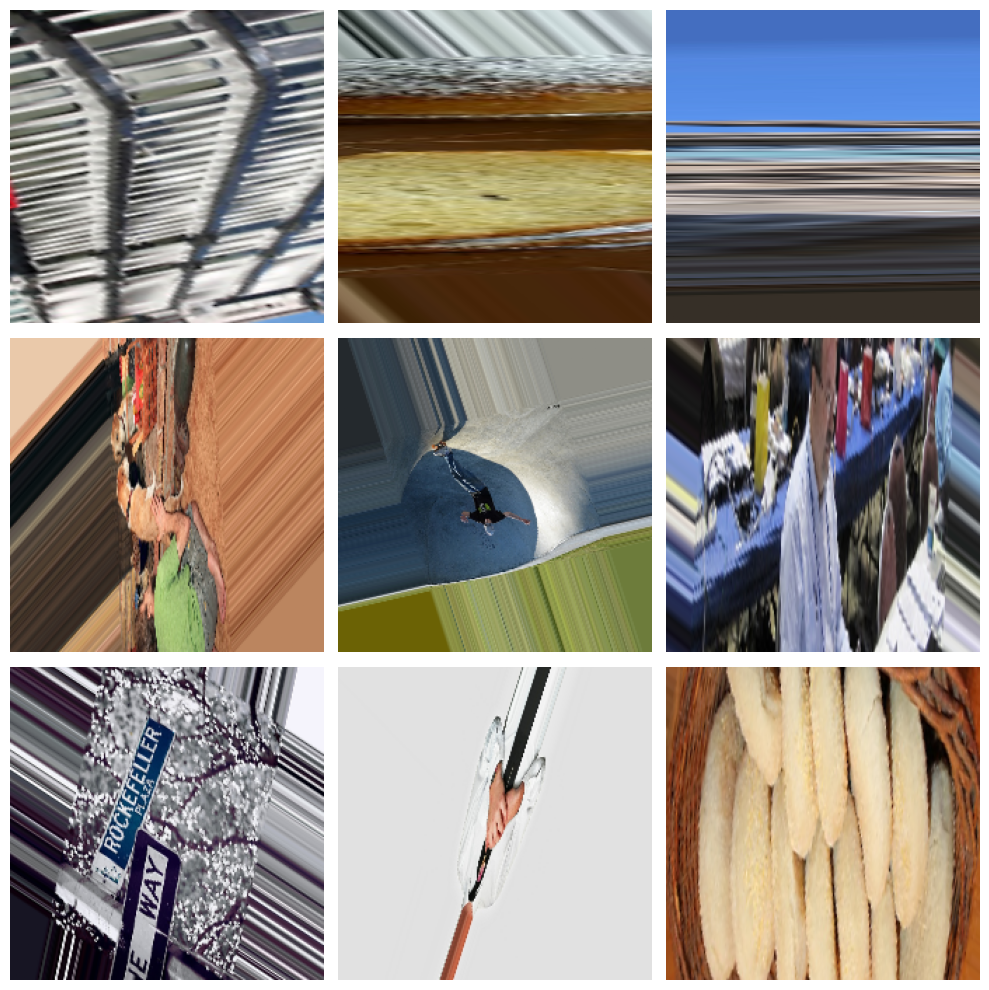

In [38]:
import matplotlib.pyplot as plt

def show_images(train_generator):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Crée un grid de 3x3 pour les images
    axes = axes.flatten()
    batch = next(iter(train_generator))  # Récupère un lot d'images du générateur
    for i, ax in enumerate(axes):
        if i < len(batch):  # Vérifie si l'index est inférieur au nombre d'images dans le lot
            ax.imshow(batch[i])  # Affiche l'image dans le subplot
            ax.axis('off')  # Désactive les axes
    plt.tight_layout()  # Ajuste la disposition
    plt.show()

# Appelez la fonction pour montrer les images
show_images(train_generator)


## 2. Création d'un jeu de données bruité

In [39]:
import numpy as np

def add_noise(img, noise_level=0.1):
    # Choisissez un type de bruit aléatoirement
    noise_types = ['gaussian', 'salt_pepper', 'poisson']
    noise_type = np.random.choice(noise_types)

    if noise_type == 'gaussian':
        noise = np.random.normal(loc=0.0, scale=noise_level, size=img.shape)
        img_noisy = img + noise
    elif noise_type == 'salt_pepper':
        row, col, ch = img.shape
        s_vs_p = 0.5
        amount = noise_level
        out = np.copy(img)
        # Salt mode
        num_salt = np.ceil(amount * img.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                  for i in img.shape]
        out[coords[0], coords[1], :] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * img.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in img.shape]
        out[coords[0], coords[1], :] = 0
        img_noisy = out
    elif noise_type == 'poisson':
        vals = len(np.unique(img))
        vals = 2 ** np.ceil(np.log2(vals))
        img_noisy = np.random.poisson(img * vals) / float(vals)
    else:
        raise ValueError("Unsupported noise type!")

    img_noisy = np.clip(img_noisy, 0, 1)  # Garantir que les valeurs restent dans [0, 1]
    return img_noisy

def noisy_generator(generator, noise_level=0.1):
    '''Generates pairs of noisy and original images.'''
    for batch in generator:
        original_batch = batch.copy()  # Copy the original images before adding noise
        noisy_batch = np.array([add_noise(image, noise_level) for image in original_batch])
        yield noisy_batch, original_batch  # Yield both the noisy and the original images



In [40]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: noisy_generator(train_generator, noise_level=0.1),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Noisy images
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)   # Original images
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: noisy_generator(validation_generator, noise_level=0.1),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Noisy images
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)   # Original images
    )
)

# Example usage with TensorFlow training loop
for x, y in train_dataset.take(1):
    print('Batch shape:', x.numpy().shape)

Batch shape: (16, 224, 224, 3)


2024-04-19 08:48:36.220458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
import matplotlib.pyplot as plt

def show_data_set_images(train_dataset):
    # Generate one batch from the dataset
    try:
        noisy_batch, original_batch = next(iter(train_dataset))
    except StopIteration:
        print("No more data available in the dataset.")
        return

    # Determine how many image pairs we can show
    num_images = len(noisy_batch)  # Get the number of images in the batch
    num_pairs_to_show = min(num_images, 9)  # Can show up to 9 pairs (since there are 18 subplots)

    # Set up the figure with a grid of 3 rows and 6 columns
    fig, axes = plt.subplots(3, 6, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(num_pairs_to_show):
        # Display the noisy image on the left
        ax_noisy = axes[2 * i]
        ax_noisy.imshow(noisy_batch[i])
        ax_noisy.axis('off')
        ax_noisy.set_title('Noisy Image')

        # Display the original image on the right
        ax_original = axes[2 * i + 1]
        ax_original.imshow(original_batch[i])
        ax_original.axis('off')
        ax_original.set_title('Original Image')

    # Hide any remaining unused axes
    for j in range(2 * num_pairs_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


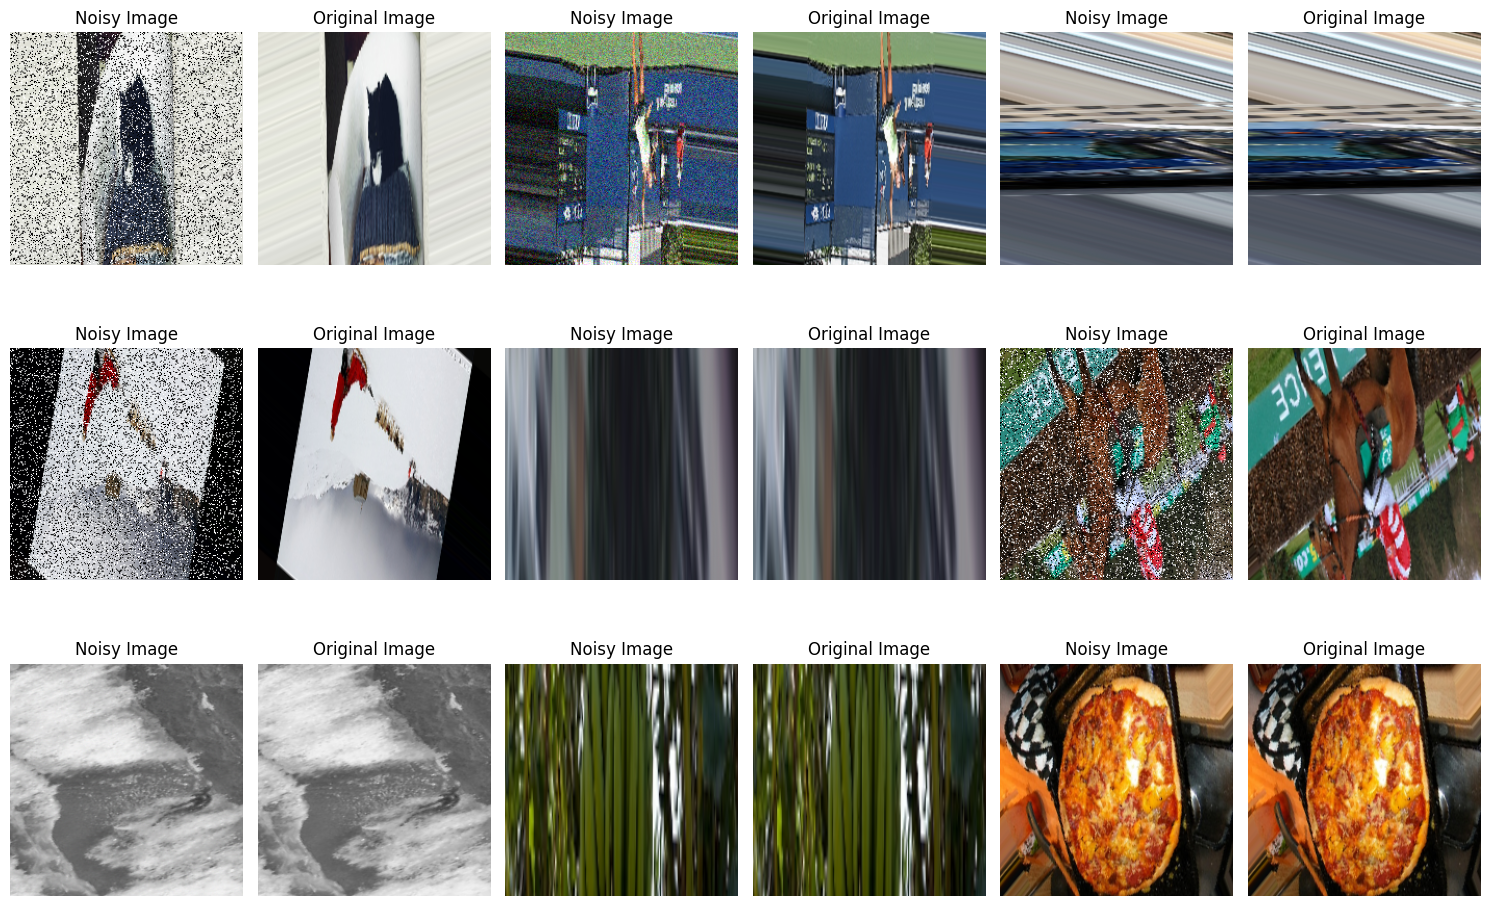

In [42]:
# Affichage des images bruitées
show_data_set_images(train_dataset)

## 3. Création du modèle auto-encodeur

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def build_autoencoder(input_shape=(224, 224, 3)):
    input_img = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(192, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(160, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(96, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(160, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)  # Ensure padding is 'same'
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Create the autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return autoencoder

# Build and summarize the autoencoder model
autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 224, 224, 192)  │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 112, 112, 192)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 112, 112, 160)  │       276,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 56, 56, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 56, 56, 96)     │       138,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 56, 56, 160)    │       138,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 112, 112, 160)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 112, 112, 192)  │       276,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 224, 224, 192)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 224, 224, 3)    │         5,187 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,651 (3.52 MB)

 Trainable params: 923,651 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Entraînement de l'autoencodeur
history = autoencoder.fit(
    x=train_dataset,  # Données d'entraînement
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,  # Données de validation
    validation_steps=VALIDATION_STEPS
)

Epoch 1/200
4/7 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step - accuracy: 0.3996 - loss: 0.0903

I0000 00:00:1713516028.638426    3495 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 36 bytes spill stores, 36 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 427ms/step - accuracy: 0.3854 - loss: 0.0884 - val_accuracy: 0.3964 - val_loss: 0.0488
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.4352 - loss: 0.0458 - val_accuracy: 0.4251 - val_loss: 0.0395
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.4437 - loss: 0.0341 - val_accuracy: 0.5638 - val_loss: 0.0273
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.5227 - loss: 0.0259 - val_accuracy: 0.6232 - val_loss: 0.0187
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.6658 - loss: 0.0150 - val_accuracy: 0.6278 - val_loss: 0.0137
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.6452 - loss: 0.0131 - val_accuracy: 0.6727 - val_loss: 0.0125
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.7043 - loss: 0.0106 - val_accuracy: 0.6567 - val_loss: 0.0111
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.6281 - loss: 0.0104 - val_accuracy: 0.6954 - val_loss: 0.0

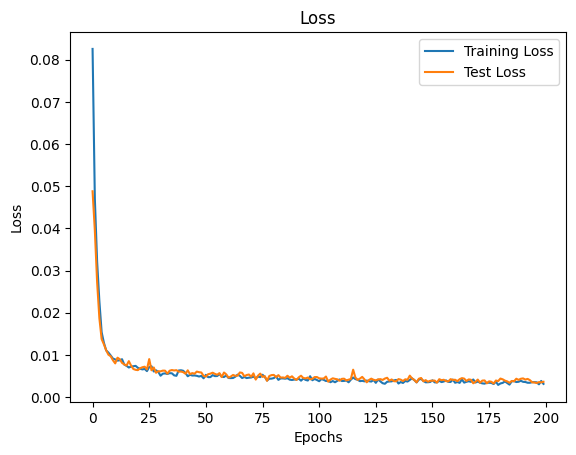

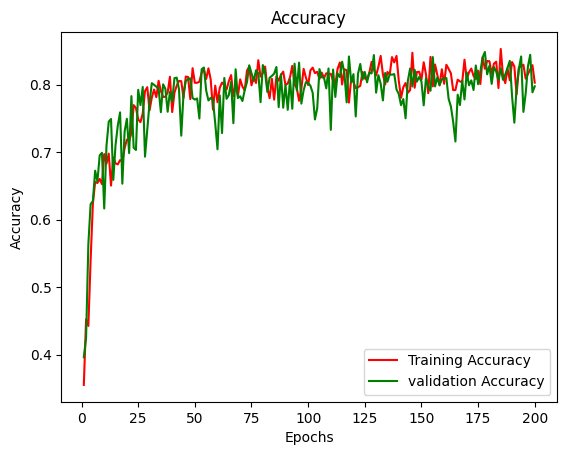

In [30]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Plotting the training accuracy
loss = history.history['loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



### Prédictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


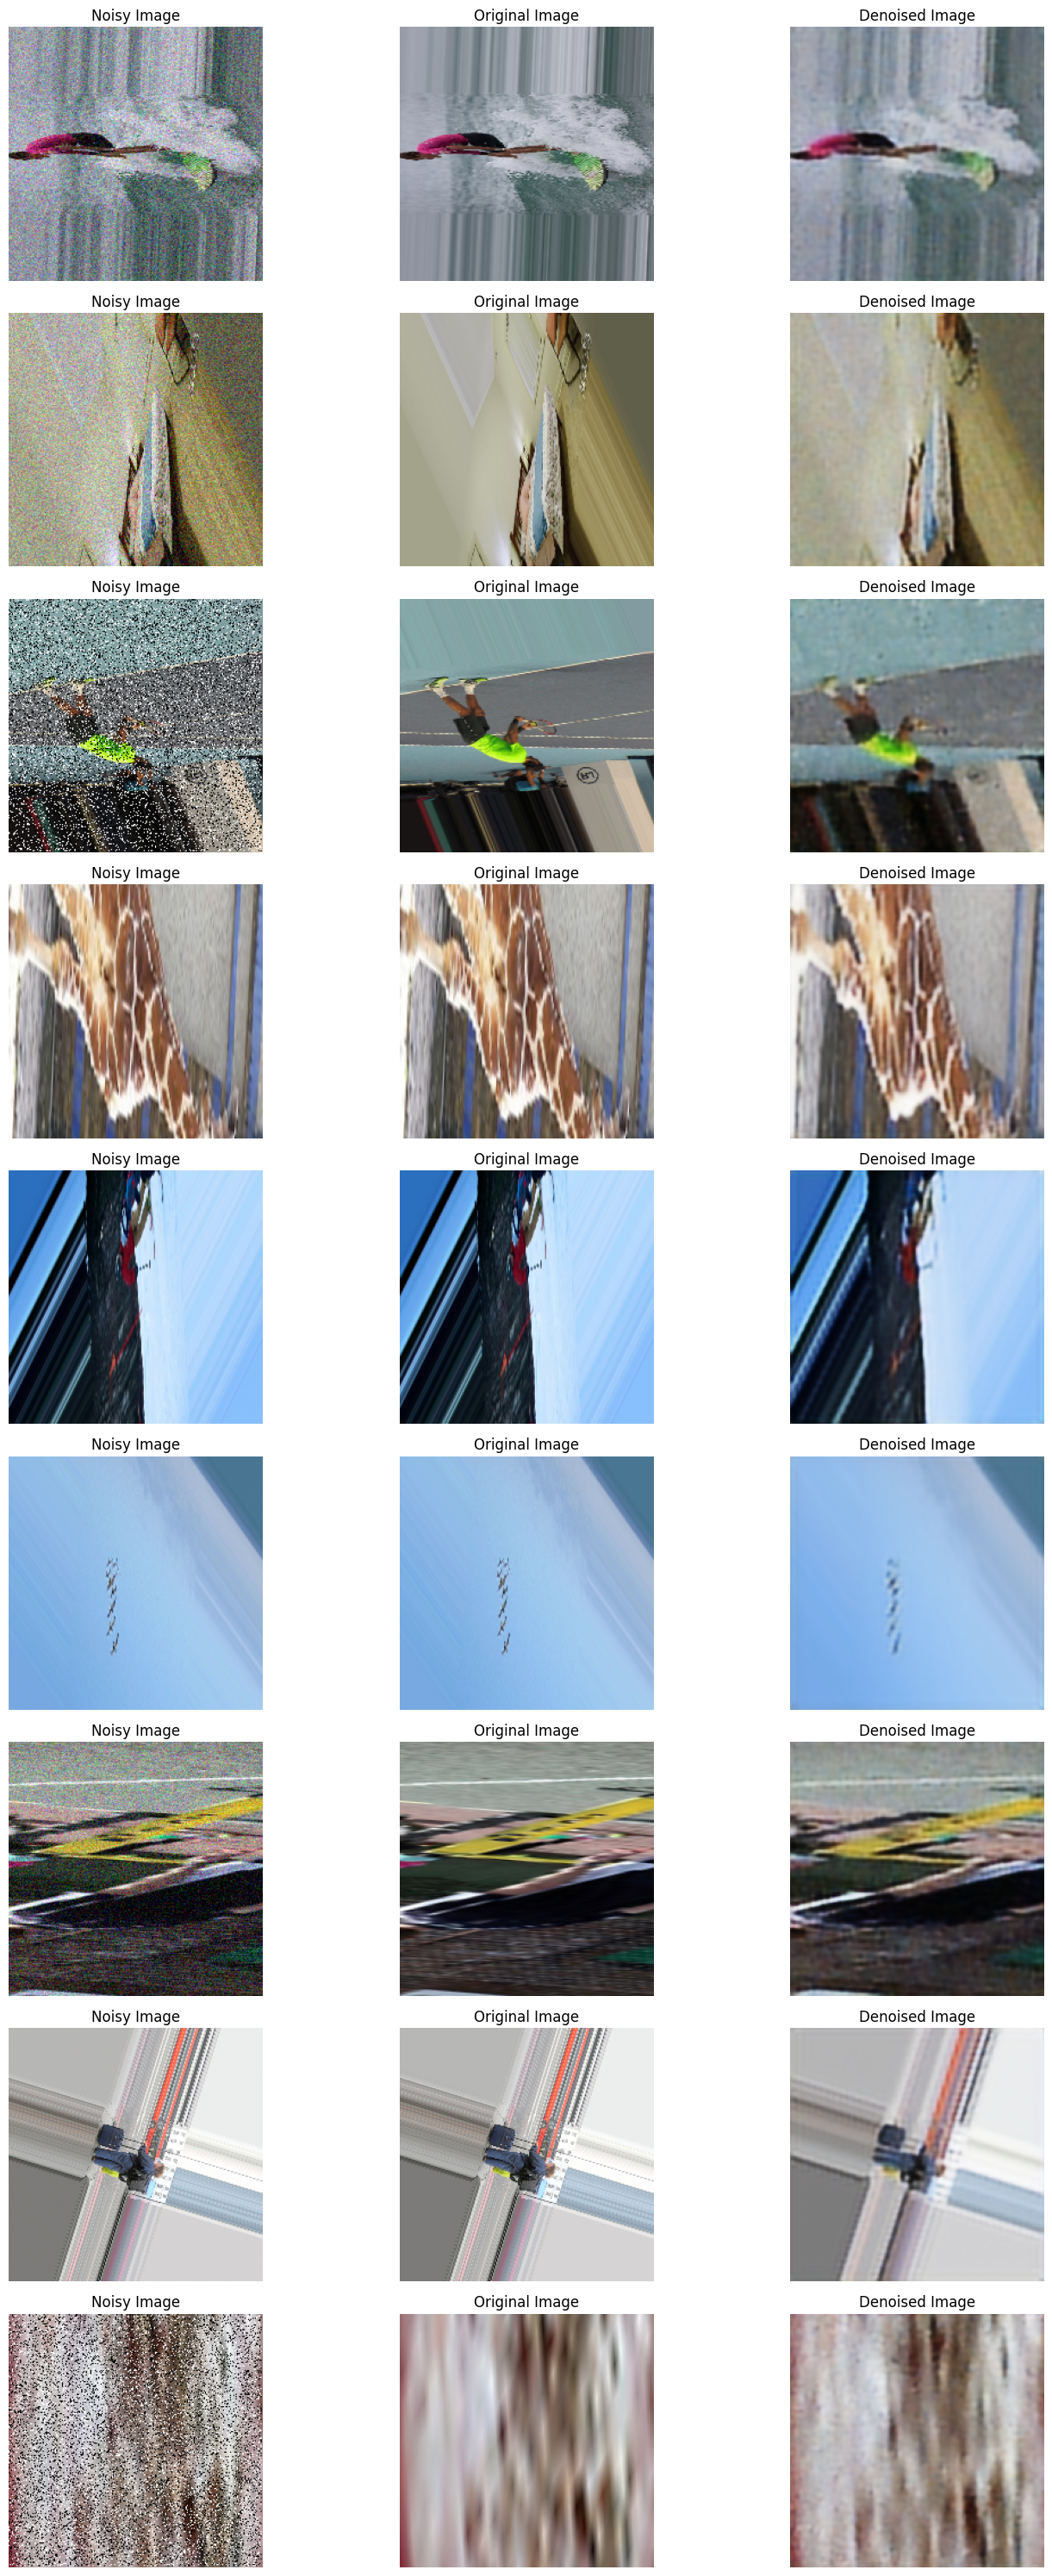

In [31]:

def show_predictions(autoencoder, dataset):
    # Generate a batch of images from the dataset
    try:
        noisy_batch, original_batch = next(iter(dataset))
    except StopIteration:
        print("No more data available in the dataset.")
        return

    # Generate denoised images using the trained autoencoder
    denoised_batch = autoencoder.predict(noisy_batch)

    # Determine how many image pairs we can show
    num_images = len(noisy_batch)  # Get the number of images in the batch
    num_pairs_to_show = min(num_images, 9)  # Can show up to 9 pairs (since there are 27 subplots)

    # Set up the figure with a grid of 9 rows and 3 columns
    fig, axes = plt.subplots(9, 3, figsize=(15, 30))
    axes = axes.flatten()

    for i in range(num_pairs_to_show):
        # Display the noisy image on the left
        ax_noisy = axes[3 * i]
        ax_noisy.imshow(noisy_batch[i])
        ax_noisy.axis('off')
        ax_noisy.set_title('Noisy Image')

        # Display the original image in the middle
        ax_original = axes[3 * i + 1]
        ax_original.imshow(original_batch[i])
        ax_original.axis('off')
        ax_original.set_title('Original Image')

        # Display the denoised image on the right
        ax_denoised = axes[3 * i + 2]
        ax_denoised.imshow(denoised_batch[i])
        ax_denoised.axis('off')
        ax_denoised.set_title('Denoised Image')

    # Hide any remaining unused axes
    for j in range(3 * num_pairs_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()



# Show the denoised images
show_predictions(autoencoder, validation_dataset)





In [32]:
import tensorflow as tf
import time

@tf.function
def predict_and_calculate_psnr(model, noisy_images, original_images):
    denoised_images = model(noisy_images, training=False)  # Ensure inference mode
    psnr_values = tf.image.psnr(original_images, denoised_images, max_val=1.0)
    return psnr_values

def evaluate_model(autoencoder, dataset, num_batches):
    psnr_values = []
    batch_count = 0
    start_time = time.time()

    # Itérer sur le dataset avec une limite sur le nombre de batches
    for noisy_batch, original_batch in dataset:
        if batch_count >= num_batches:
            break  # Arrêtez la boucle après le nombre spécifié de batches

        batch_start_time = time.time()

        # Effectuer la prédiction et calculer le PSNR
        psnr = predict_and_calculate_psnr(autoencoder, noisy_batch, original_batch)

        # Ajouter les valeurs de PSNR à la liste, en gardant les opérations dans TensorFlow
        psnr_values.append(psnr)  # Ajouter le tensor TF à la liste

        batch_end_time = time.time()
        batch_count += 1

        # Logs pour chaque batch
        print(f"Batch {batch_count}: Calculated PSNR for {len(noisy_batch)} images.")
        print(f"Time for batch {batch_count}: {batch_end_time - batch_start_time:.2f} seconds")

    total_time = time.time() - start_time

    # Concaténer toutes les valeurs de PSNR et calculer la moyenne
    all_psnr = tf.concat(psnr_values, axis=0)
    average_psnr = tf.reduce_mean(all_psnr).numpy()  # Convertir en numpy après les calculs

    # Logs de processus final
    print(f"Evaluated {batch_count} batches in total.")
    print(f"Total evaluation time: {total_time:.2f} seconds")
    print(f"Average PSNR: {average_psnr:.2f} dB")

    return average_psnr

# Supposons que vous ayez défini VALIDATION_STEPS quelque part
psnr = evaluate_model(autoencoder, validation_dataset, VALIDATION_STEPS)
print(f'Average PSNR: {psnr:.2f} dB')


Batch 1: Calculated PSNR for 13 images.
Time for batch 1: 3.58 seconds
Batch 2: Calculated PSNR for 16 images.
Time for batch 2: 5.12 seconds
Evaluated 2 batches in total.
Total evaluation time: 9.22 seconds
Average PSNR: 24.65 dB
Average PSNR: 24.65 dB


## Tuning 

In [45]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, Hyperband

class AutoencoderHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
        
    def build(self, hp):
        input_img = Input(shape=self.input_shape)
        # Encoder
        x = Conv2D(
            filters=hp.Int('encoder_filter_1', min_value=32, max_value=160, step=32),
            kernel_size=hp.Choice('encoder_kernel_size_1', values=[3, 5]),
            activation='relu',
            padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(
            filters=hp.Int('encoder_filter_2', min_value=32, max_value=160, step=32),
            kernel_size=hp.Choice('encoder_kernel_size_2', values=[3, 5]),
            activation='relu',
            padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(
            filters=hp.Int('encoder_filter_3', min_value=32, max_value=160, step=32),
            kernel_size=hp.Choice('encoder_kernel_size_3', values=[3, 5]),
            activation='relu',
            padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        # Decoder
        x = Conv2D(
            filters=hp.Int('decoder_filter_1', min_value=32, max_value=160, step=32),
            kernel_size=hp.Choice('decoder_kernel_size_1', values=[3, 5]),
            activation='relu',
            padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(
            filters=hp.Int('decoder_filter_2', min_value=32, max_value=160, step=32),
            kernel_size=hp.Choice('decoder_kernel_size_2', values=[3, 5]),
            activation='relu',
            padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(
            filters=hp.Int('decoder_filter_3', min_value=32, max_value=160, step=32),
            kernel_size=hp.Choice('decoder_kernel_size_3', values=[3, 5]),
            activation='relu',
            padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer=Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='mse', metrics=["accuracy"])

        return autoencoder

input_shape = (224, 224, 3)
hypermodel = AutoencoderHyperModel(input_shape)

tuner = Hyperband(
    hypermodel,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='autoencoder_tuning',
    project_name='autoencoder_denoise',
    seed=42
)

# Perform the hyperparameter tuning
tuner.search(train_dataset, validation_data=validation_dataset, epochs=10, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
# Print all the best hyperparameters for all Conv2D layers
print("Best encoder hyperparameters:")
print(f"Encoder filter 1: {best_hps.get('encoder_filter_1')}")
print(f"Encoder kernel size 1: {best_hps.get('encoder_kernel_size_1')}")
print(f"Encoder filter 2: {best_hps.get('encoder_filter_2')}")
print(f"Encoder kernel size 2: {best_hps.get('encoder_kernel_size_2')}")
print("Best decoder hyperparameters:")
print(f"Decoder filter 1: {best_hps.get('decoder_filter_1')}")
print(f"Decoder kernel size 1: {best_hps.get('decoder_kernel_size_1')}")
print(f"Decoder filter 2: {best_hps.get('decoder_filter_2')}")
print(f"Decoder kernel size 2: {best_hps.get('decoder_kernel_size_2')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

# Build the model with the best hyperparameters and show its summary
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

IndentationError: unexpected indent (1940278773.py, line 44)

## 4. Sauvegarde de l'autoencodeur

In [34]:
autoencoder.save('livrable_2_autoencoder.keras')  # Sauvegarde du modèle